In [1]:
"""Outliers."""

'Outliers.'

# Выбросы в данных

In [ ]:
import io
import os

import h2o
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import scipy.stats as st
import seaborn as sns
from dotenv import load_dotenv

# импортируем класс Extended Isolation Forest
from h2o.estimators import H2OExtendedIsolationForestEstimator
from scipy import stats  # pylint: disable=W0404
from sklearn import tree
from sklearn.datasets import load_iris
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [4]:
sns.set(rc={"figure.figsize": (10, 10)})

## Влияние выбросов

### Статистический тест

In [5]:
np.random.seed(42)
height = list(np.round(np.random.normal(180, 10, 1000)))
print(height)

[np.float64(185.0), np.float64(179.0), np.float64(186.0), np.float64(195.0), np.float64(178.0), np.float64(178.0), np.float64(196.0), np.float64(188.0), np.float64(175.0), np.float64(185.0), np.float64(175.0), np.float64(175.0), np.float64(182.0), np.float64(161.0), np.float64(163.0), np.float64(174.0), np.float64(170.0), np.float64(183.0), np.float64(171.0), np.float64(166.0), np.float64(195.0), np.float64(178.0), np.float64(181.0), np.float64(166.0), np.float64(175.0), np.float64(181.0), np.float64(168.0), np.float64(184.0), np.float64(174.0), np.float64(177.0), np.float64(174.0), np.float64(199.0), np.float64(180.0), np.float64(169.0), np.float64(188.0), np.float64(168.0), np.float64(182.0), np.float64(160.0), np.float64(167.0), np.float64(182.0), np.float64(187.0), np.float64(182.0), np.float64(179.0), np.float64(177.0), np.float64(165.0), np.float64(173.0), np.float64(175.0), np.float64(191.0), np.float64(183.0), np.float64(162.0), np.float64(183.0), np.float64(176.0), np.float64(

In [ ]:
t_statistic, p_value = st.ttest_1samp(height, 182)
p_value

np.float64(9.035492171563735e-09)

In [7]:
height.append(1000)

t_statistic, p_value = st.ttest_1samp(height, 182)
p_value

np.float64(0.26334958447468043)

### Линейная регрессия

In [ ]:
load_dotenv()

anscombe_json_url = os.environ.get("ANSCOMBE_JSON_URL", "")
response = requests.get(anscombe_json_url)
anscombe = pd.read_json(io.BytesIO(response.content))
anscombe = anscombe[anscombe.Series == "III"]
anscombe.head()

,Series,X,Y
22,III,10,7.46
23,III,8,6.77
24,III,13,12.74
25,III,9,7.11
26,III,11,7.81


In [9]:
a_var, b_var = anscombe.X, anscombe.Y

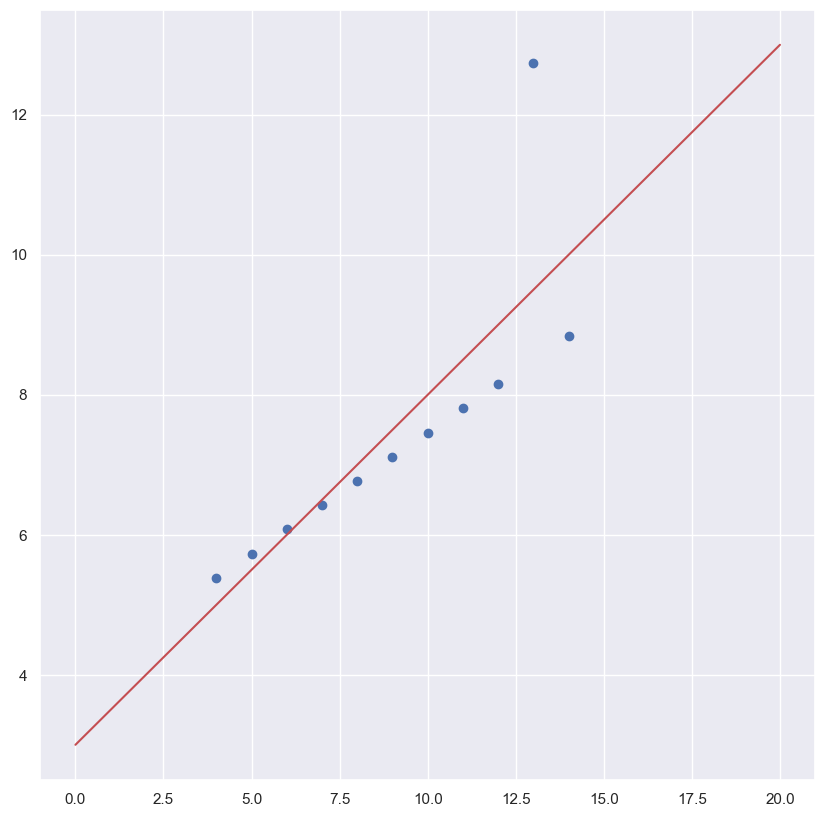

In [10]:
plt.scatter(a_var, b_var)

slope, intercept = np.polyfit(a_var, b_var, deg=1)

x_vals = np.linspace(0, 20, num=1000)
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, "r")

plt.show()

In [11]:
print(np.corrcoef(a_var, b_var)[0][1])

0.8162867394895984


In [12]:
# будем считать выбросом наблюдение с индексом 24
a_var.drop(index=24, inplace=True)
b_var.drop(index=24, inplace=True)

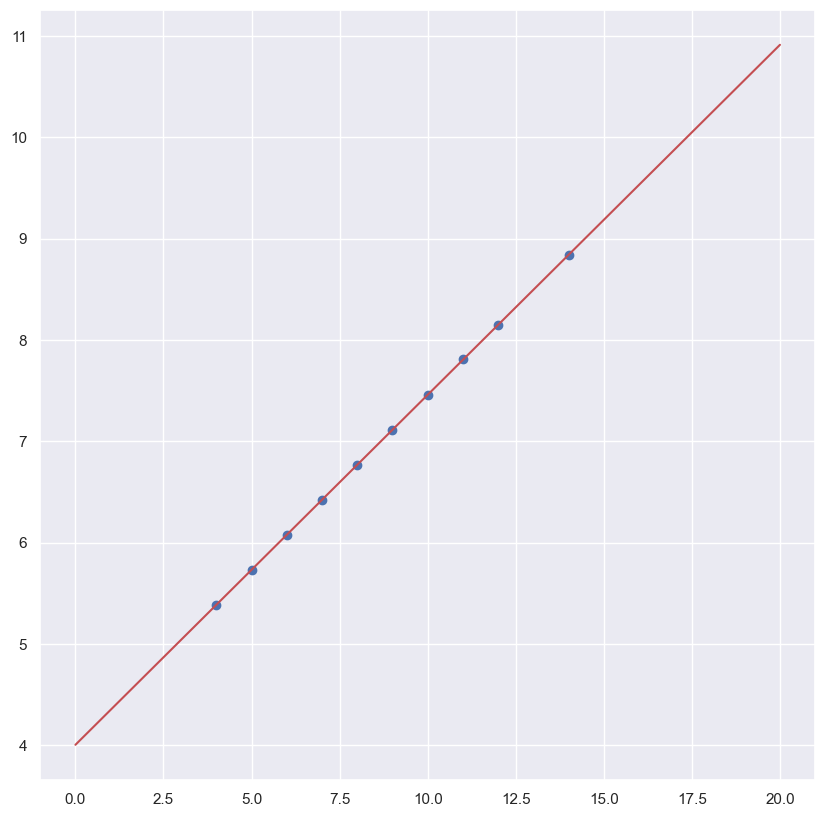

In [13]:
plt.scatter(a_var, b_var)

slope, intercept = np.polyfit(a_var, b_var, deg=1)

x_vals = np.linspace(0, 20, num=1000)
y_vals = intercept + slope * x_vals
plt.plot(x_vals, y_vals, "r")

plt.show()

In [14]:
print(np.corrcoef(a_var, b_var)[0][1])

0.9999965537848283


## Статистические методы

In [ ]:
load_dotenv()

boston_csv_url = os.environ.get("BOSTON_CSV_URL", "")
response = requests.get(boston_csv_url)
boston = pd.read_csv(io.BytesIO(response.content))

### boxplot

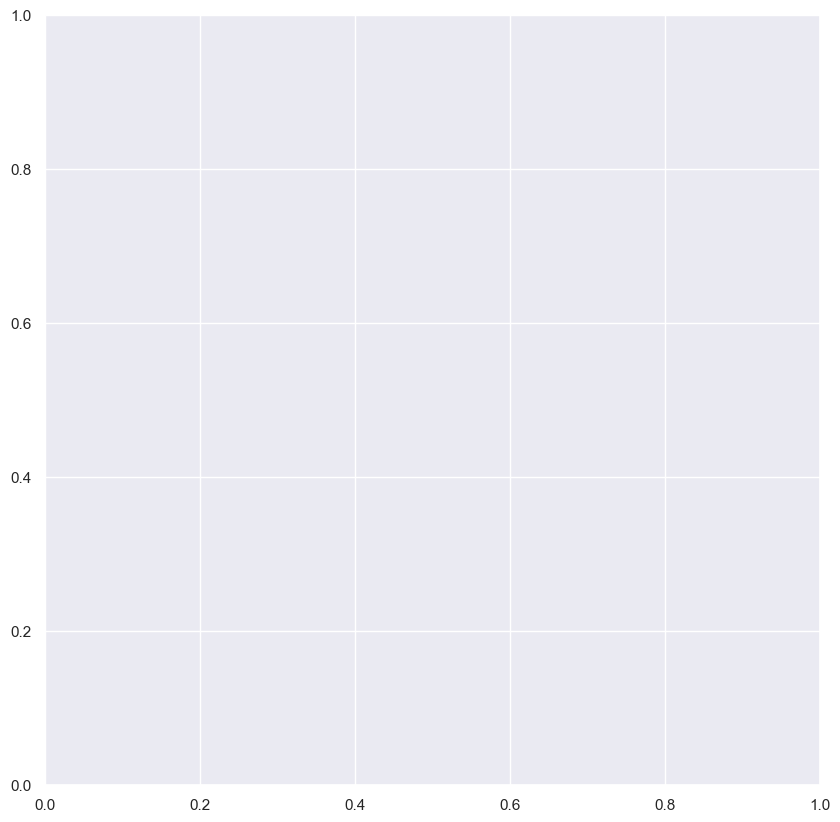

In [16]:
# усы имеют длину Q1 - 1.5 * IQR и Q3 + 1.5 * IQR
sns.boxplot(a_var=boston.RM);

### scatter plot

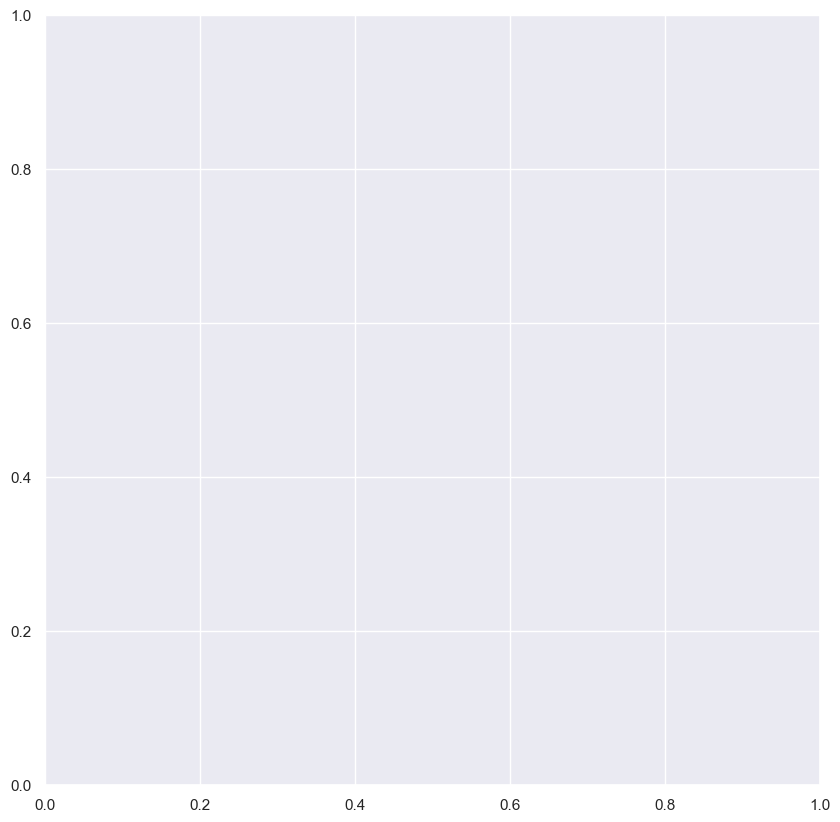

In [17]:
sns.scatterplot(a_var=boston.RM, b_var=boston.MEDV);

### z-score

In [ ]:
# посмотрим на сколько СКО значение отклоняется от среднего
c_var = stats.zscore(boston)
c_var_df = pd.DataFrame(c_var, columns=boston.columns)
c_var_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,-0.419782,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,0.159686
1,-0.417339,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.101524
2,-0.417342,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,1.324247
3,-0.416750,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,1.182758
4,-0.412482,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,1.487503


Найдем выбросы в датафрейме

In [19]:
# найдем те значения, которые отклоняются больше, чем на три СКО
# технически, метод .any() выводит True для тех строк (axis = 1),
# где хотя бы одно значение True (т.е. > 3)
boston[(np.abs(c_var) > 3).any(axis=1)].head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
55,0.01311,90.0,1.22,0.0,0.403,7.249,21.9,8.6966,5.0,226.0,17.9,395.93,4.81,35.4
56,0.02055,85.0,0.74,0.0,0.410,6.383,35.7,9.1876,2.0,313.0,17.3,396.90,5.77,24.7
57,0.01432,100.0,1.32,0.0,0.411,6.816,40.5,8.3248,5.0,256.0,15.1,392.90,3.95,31.6
102,0.22876,0.0,8.56,0.0,0.520,6.405,85.4,2.7147,5.0,384.0,20.9,70.80,10.63,18.6
141,1.62864,0.0,21.89,0.0,0.624,5.019,100.0,1.4394,4.0,437.0,21.2,396.90,34.41,14.4


Удалим выбросы в столбце

In [20]:
# выведем True там, где в столбце RM значение меньше трех СКО
col_mask = np.abs(c_var[:, boston.columns.get_loc("RM")]) < 3

# применяем маску к датафрейму
print(boston.loc[col_mask, "RM"].head())

0    6.575
1    6.421
2    7.185
3    6.998
4    7.147
Name: RM, dtype: float64


Удалим выбросы во всем датафрейме

In [21]:
# если в строке (axis = 1) есть хотя бы один False как следствие условия np.abs(z) < 3,
# метод .all() вернет логический массив, который можно использовать как фильтр
z_mask = (np.abs(c_var) < 3).all(axis=1)

boston_z = boston[z_mask]
boston_z.shape

(415, 14)

In [22]:
boston[["RM", "MEDV"]].corr()

,RM,MEDV
RM,1.00000,0.69536
MEDV,0.69536,1.00000


In [23]:
boston_z[["RM", "MEDV"]].corr()

,RM,MEDV
RM,1.000000,0.734041
MEDV,0.734041,1.000000


### Измененный z-score

In [24]:
# рассчитаем MAD
median = boston.median()
dev_median = boston - (boston.median())
abs_dev_median = np.abs(dev_median)
MAD = abs_dev_median.median()

# рассчитаем измененный z-score
# добавим константу, чтобы избежать деления на ноль
zmod = (0.6745 * (boston - boston.median())) / (MAD + 1e-5)

# создадим фильтр
zmod_mask = (np.abs(zmod) < 3.5).all(axis=1)

# выведем результат
boston_zmod = boston[zmod_mask]
boston_zmod.shape

(168, 14)

In [25]:
# посмотрим на корреляцию
boston_zmod[["RM", "MEDV"]].corr().iloc[0, 1].round(3)

np.float64(0.719)

### IQR

In [26]:
# в стандартном нормальном распределении
# соотношение z-score и Q1, Q3:
q1 = -0.6745
q3 = 0.6745

iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

# тогда lower_bound и upper_bound почти равны трем СКО от среднего
# (было бы точнее, если использовать 1.75)
print(lower_bound, upper_bound)

-2.698 2.698


Удаление выбросов в столбце

In [27]:
# найдем границы 1.5 * IQR
q1 = boston.RM.quantile(0.25)
q3 = boston.RM.quantile(0.75)

iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

print(lower_bound, upper_bound)

4.778499999999999 7.730500000000001


In [28]:
# применим эти границы, чтобы найти выбросы в столбце RM
boston[(boston.RM < lower_bound) | (boston.RM > upper_bound)].head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
97,0.12083,0.0,2.89,0.0,0.445,8.069,76.0,3.4952,2.0,276.0,18.0,396.90,4.21,38.7
98,0.08187,0.0,2.89,0.0,0.445,7.820,36.9,3.4952,2.0,276.0,18.0,393.53,3.57,43.8
162,1.83377,0.0,19.58,1.0,0.605,7.802,98.2,2.0407,5.0,403.0,14.7,389.61,1.92,50.0
163,1.51902,0.0,19.58,1.0,0.605,8.375,93.9,2.1620,5.0,403.0,14.7,388.45,3.32,50.0
166,2.01019,0.0,19.58,0.0,0.605,7.929,96.2,2.0459,5.0,403.0,14.7,369.30,3.70,50.0


In [29]:
# найдем значения без выбросов (переворачиваем маску)
boston[~(boston.RM < lower_bound) | (boston.RM > upper_bound)].head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Удаление выбросов в датафрейме

In [30]:
# найдем границы 1.5 * IQR по каждому столбцу
Q1 = boston.quantile(0.25)
Q3 = boston.quantile(0.75)
IQR = Q3 - Q1
lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

# создадим маску для выбросов
# если хотя бы один выброс в строке (True), метод .any() сделает всю строку True
mask_out = ((boston < lower) | (boston > upper)).any(axis=1)

In [31]:
# найдем выбросы во всем датафрейме
boston[mask_out].shape

(238, 14)

In [32]:
# возьмем датафрейм без выбросов
boston[~mask_out].shape

(268, 14)

In [33]:
# обратное условие, если все значения по всем строкам внутри границ
# метод .all() выдаст True
mask_no_out = ((boston >= lower) & (boston <= upper)).all(axis=1)

In [34]:
# выведем датафрейм без выбросов
boston[mask_no_out].shape

(268, 14)

In [35]:
# выведем выбросы
boston[~mask_no_out].shape

(238, 14)

In [36]:
# сохраним результат
boston_iqr = boston[mask_no_out]

In [37]:
boston_iqr[["RM", "MEDV"]].corr()

,RM,MEDV
RM,1.000000,0.644819
MEDV,0.644819,1.000000


## Методы, основанные на модели

### Isolation Forest

#### Принцип изолирующего дерева

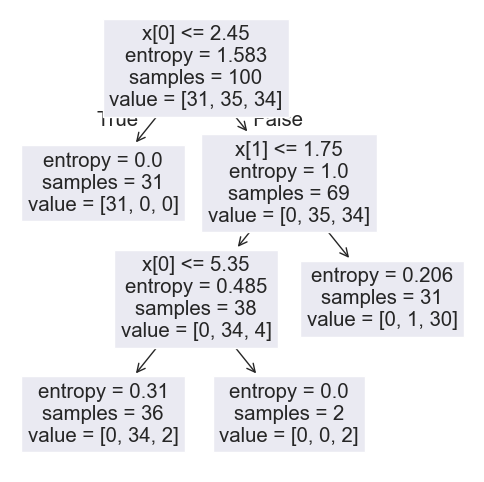

In [38]:
# рассмотрим пример классификации с помощью решающего дерева


iris = load_iris()

df = pd.DataFrame(iris.data[:, [2, 3]], columns=["petal_l", "petal_w"])
df["target"] = iris.target

d_var = df[["petal_l", "petal_w"]]
e_var = df.target


D_train, D_test, e_train, e_test = train_test_split(
    d_var, e_var, test_size=1 / 3, random_state=42
)


clf = DecisionTreeClassifier(criterion="entropy", max_leaf_nodes=4, random_state=42)

clf.fit(D_train, e_train)

plt.figure(figsize=(6, 6))
tree.plot_tree(clf)
plt.show()

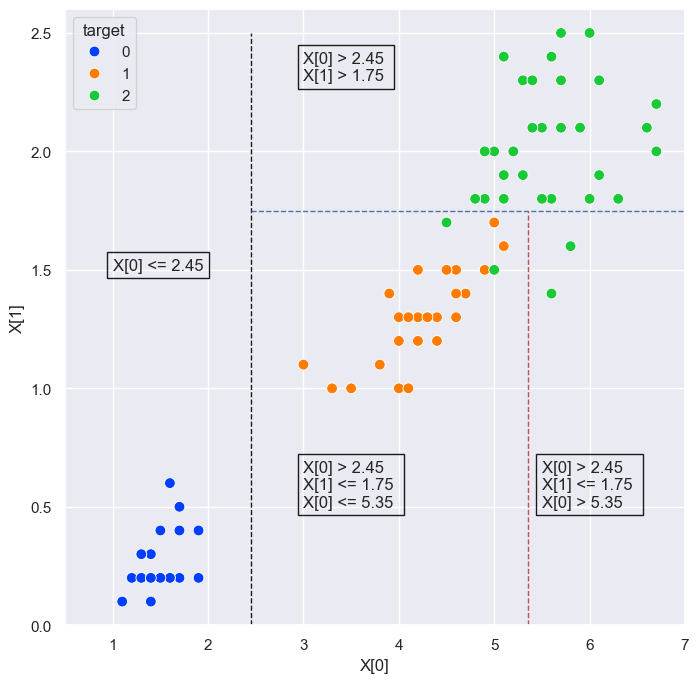

In [39]:
plt.figure(figsize=(8, 8))
ax = plt.axes()

sns.scatterplot(
    x=D_train.petal_l,  # noqa: VNE001
    y=D_train.petal_w,  # noqa: VNE001
    hue=df.target,
    palette="bright",
    s=60,
)

ax.vlines(
    x=2.45,  # noqa: VNE001
    ymin=0,
    ymax=2.5,
    linewidth=1,
    color="k",
    linestyles="--",
)
ax.text(
    1, 1.5, "X[0] <= 2.45", fontsize=12, bbox={"facecolor": "none", "edgecolor": "k"}
)

ax.hlines(
    y=1.75, xmin=2.45, xmax=7, linewidth=1, color="b", linestyles="--"  # noqa: VNE001
)
ax.text(
    3,
    2.3,
    "X[0] > 2.45 \nX[1] > 1.75",
    fontsize=12,
    bbox={"facecolor": "none", "edgecolor": "k"},
)

ax.vlines(x=5.35, ymin=0, ymax=1.75, linewidth=1, color="r", linestyles="--")
ax.text(
    3,
    0.5,
    "X[0] > 2.45 \nX[1] <= 1.75 \nX[0] <= 5.35",
    fontsize=12,
    bbox={"facecolor": "none", "edgecolor": "k"},
)
ax.text(
    5.5,
    0.5,
    "X[0] > 2.45 \nX[1] <= 1.75 \nX[0] > 5.35",
    fontsize=12,
    bbox={"facecolor": "none", "edgecolor": "k"},
)

plt.xlim([0.5, 7])
plt.ylim([0, 2.6])

plt.xlabel("X[0]")
plt.ylabel("X[1]")

plt.show()

#### iForest в sklearn

##### Пример из sklearn

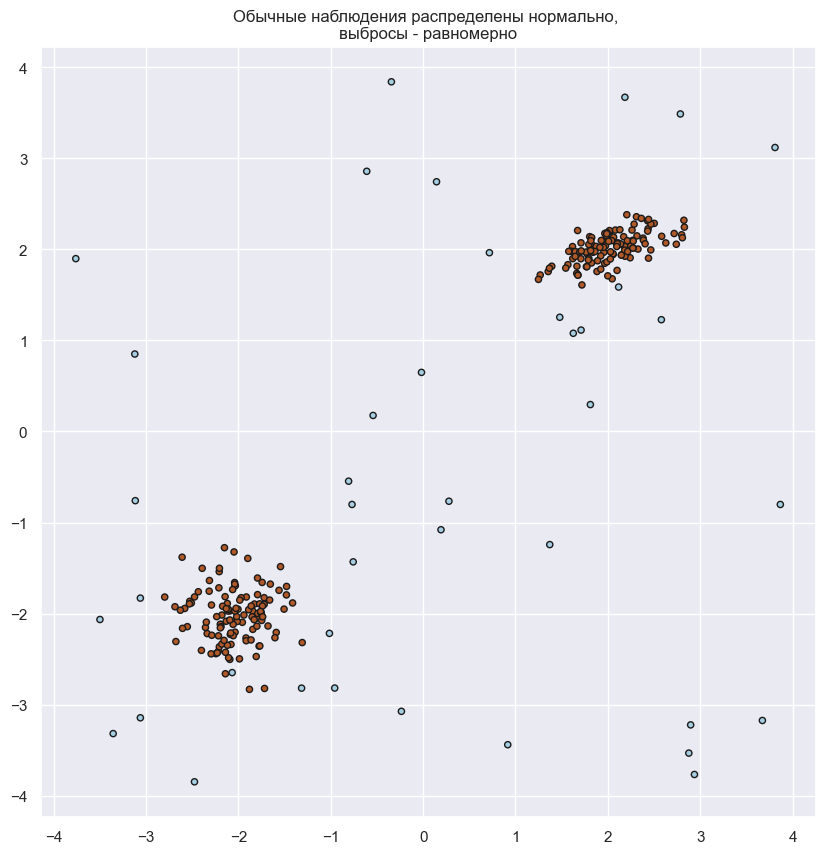

In [40]:
# зададим количество обычных наблюдений и выбросов
n_samples, n_outliers = 120, 40
rng = np.random.RandomState(0)


# создадим вытянутое (за счет умножения на covariance)
covariance = np.array([[0.5, -0.1], [0.7, 0.4]])
# и сдвинутое вверх вправо
shift = np.array([2, 2])
# облако объектов
cluster_1 = 0.4 * rng.randn(n_samples, 2) @ covariance + shift

# создадим сферическое и сдвинутое вниз влево облако объектов
cluster_2 = 0.3 * rng.randn(n_samples, 2) + np.array([-2, -2])

# создадим выбросы
outliers = rng.uniform(low=-4, high=4, size=(n_outliers, 2))

# создадим пространство из двух признаков
h_var = np.concatenate([cluster_1, cluster_2, outliers])

# а также целевую переменную (1 для обычных наблюдений, -1 для выбросов)
i_var = np.concatenate(
    [np.ones((2 * n_samples), dtype=int), -np.ones((n_outliers), dtype=int)]
)

scatter = plt.scatter(
    h_var[:, 0], h_var[:, 1], c=i_var, cmap="Paired", s=20, edgecolor="k"
)

plt.title("Обычные наблюдения распределены нормально, \nвыбросы - равномерно")

plt.show()

In [41]:
# разделим выборку
D_train, D_test, e_train, e_test = train_test_split(
    h_var, i_var, stratify=i_var, random_state=42
)

# параметр stratify сделает так, что и в тестовой, и в обучающей выборке
# будет одинаковая доля выбросов
_, y_train_counts = np.unique(e_train, return_counts=True)
_, y_test_counts = np.unique(e_test, return_counts=True)

print(
    np.round(y_train_counts / len(e_train), 2), np.round(y_test_counts / len(e_test), 2)
)

[0.14 0.86] [0.14 0.86]


In [42]:
# обучим алгоритм
isof = IsolationForest(max_samples=len(D_train), random_state=0)
isof.fit(D_train)

IsolationForest(max_samples=210, random_state=0)

In [43]:
# сделаем прогноз на тесте и посмотрим результат
y_pred = isof.predict(D_test)


accuracy_score(e_test, y_pred)

0.9428571428571428

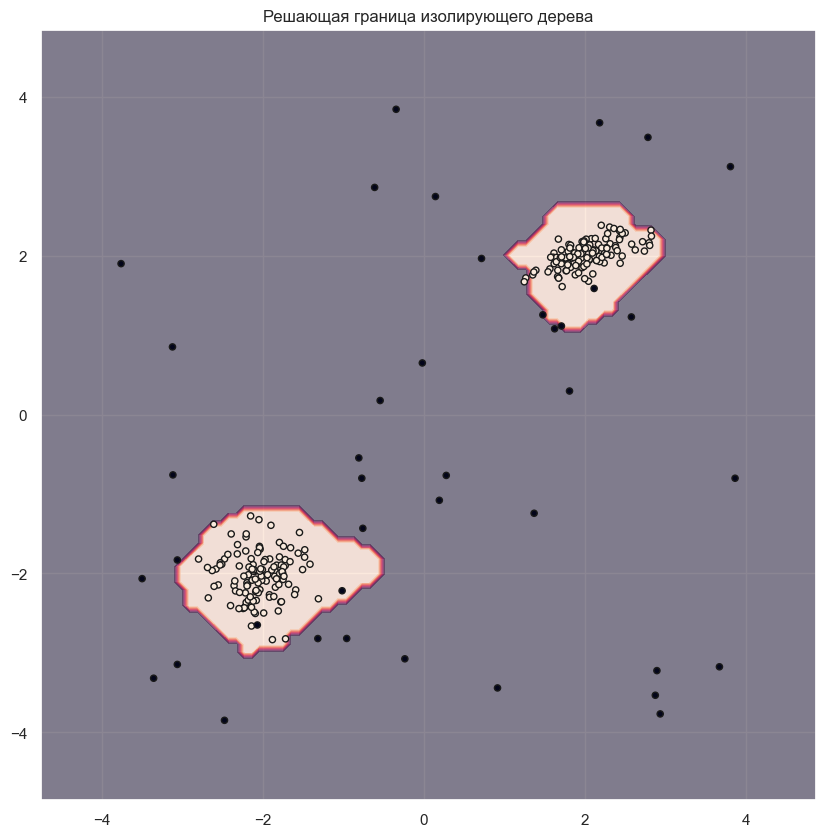

In [44]:
disp = DecisionBoundaryDisplay.from_estimator(
    isof,
    h_var,
    response_method="predict",
    alpha=0.5,
)
disp.ax_.scatter(h_var[:, 0], h_var[:, 1], c=i_var, s=20, edgecolor="k")
disp.ax_.set_title("Решающая граница изолирующего дерева")
plt.show()

##### Настройка гиперпараметров

In [45]:
X_ = [[-1], [2], [3], [5], [7], [10], [12], [20], [30], [100]]

In [46]:
clf = IsolationForest(contamination="auto", random_state=42).fit(X_)
print(clf.predict(X_))
print(clf.decision_function(X_))

[-1  1  1  1  1  1  1  1 -1 -1]
[-0.00403873  0.10617494  0.11864618  0.11188085  0.11479849  0.09281731
  0.0780247   0.00948311 -0.08497048 -0.27336568]


In [47]:
clf = IsolationForest(contamination=0.1, random_state=42).fit(X_)
print(clf.predict(X_))
print(clf.decision_function(X_))

[ 1  1  1  1  1  1  1  1  1 -1]
[ 0.09977127  0.20998494  0.22245618  0.21569085  0.21860849  0.19662731
  0.1818347   0.11329311  0.01883952 -0.16955568]


In [48]:
clf = IsolationForest(contamination=0.2, random_state=42).fit(X_)
print(clf.predict(X_))
print(clf.decision_function(X_))

[ 1  1  1  1  1  1  1  1 -1 -1]
[ 0.01618635  0.12640002  0.13887126  0.13210593  0.13502358  0.11304239
  0.09824979  0.02970819 -0.0647454  -0.25314059]


##### Датасет boston

In [49]:
X_boston = boston.drop(columns="MEDV")
y_boston = boston.MEDV

clf = IsolationForest(max_samples=100, random_state=0)
clf.fit(X_boston)

# создадим столбец с anomaly_score
boston["scores"] = clf.decision_function(X_boston)
# и результатом (выброс (-1) или нет (1))
boston["anomaly"] = clf.predict(X_boston)

# посмотрим на количество выбросов
boston[boston.anomaly == -1].shape[0]

106

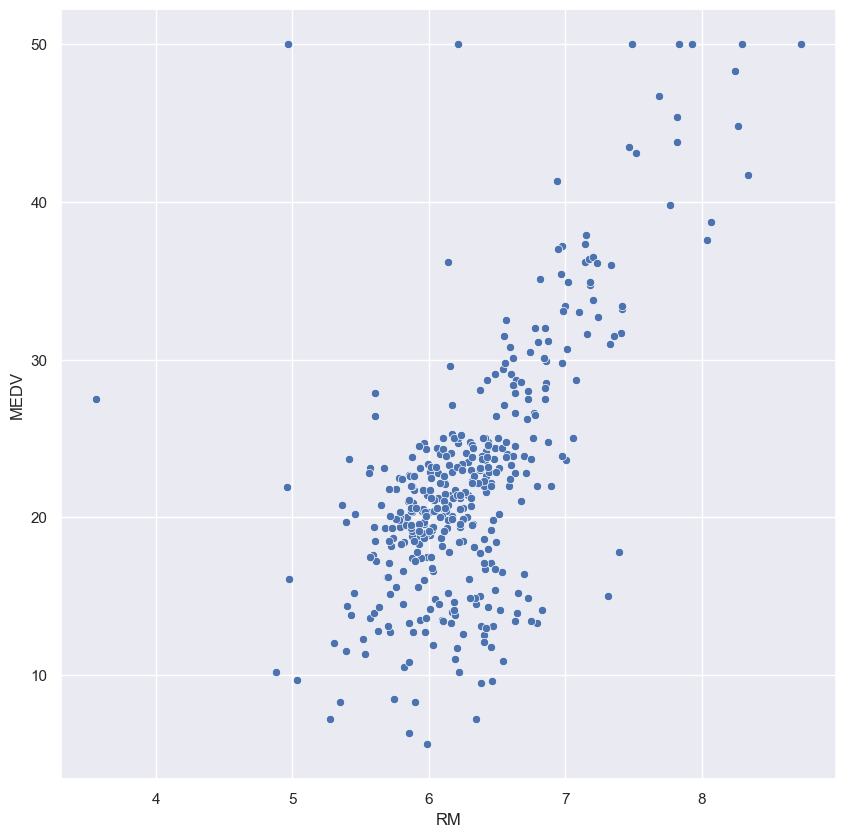

In [50]:
boston_ifor = boston[boston.anomaly == 1]
sns.scatterplot(x=boston_ifor.RM, y=boston_ifor.MEDV);

In [51]:
boston_ifor[["RM", "MEDV"]].corr()

,RM,MEDV
RM,1.0000,0.6612
MEDV,0.6612,1.0000


##### Недостаток алгоритма

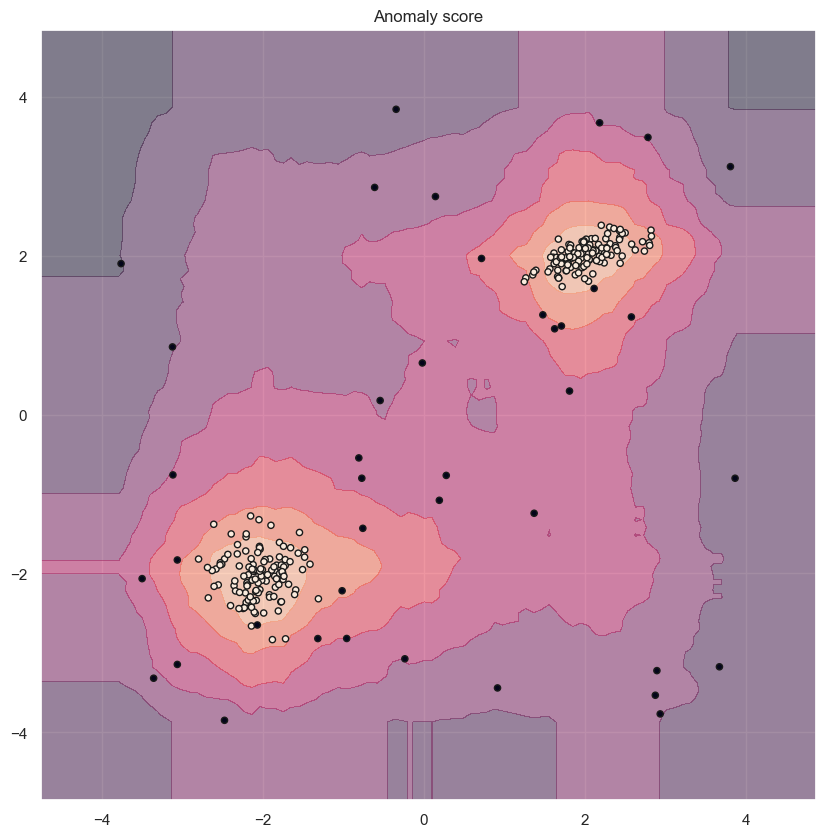

In [52]:
disp = DecisionBoundaryDisplay.from_estimator(
    isof,
    h_var,
    response_method="decision_function",
    alpha=0.5,
)
disp.ax_.scatter(h_var[:, 0], h_var[:, 1], c=i_var, s=20, edgecolor="k")
disp.ax_.set_title("Anomaly score")
plt.show()

### Extended Isolation Forest

#### Установка h2o

In [53]:
!pip install h2o

In [54]:
print(os.environ.get("JAVA_HOME"))
print(os.environ.get("PATH"))

C:\Users\Ruslan\AppData\Local\Programs\Java\zulu24-jre
c:\Users\Ruslan\miniconda3;C:\Users\Ruslan\miniconda3;C:\Users\Ruslan\miniconda3\Library\mingw-w64\bin;C:\Users\Ruslan\miniconda3\Library\usr\bin;C:\Users\Ruslan\miniconda3\Library\bin;C:\Users\Ruslan\miniconda3\Scripts;C:\Users\Ruslan\miniconda3\bin;C:\Users\Ruslan\miniconda3\condabin;c:\Users\Ruslan\AppData\Local\Programs\cursor\resources\app\bin;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files\Git\cmd;C:\Users\Ruslan\AppData\Local\Programs\Python\Python312;C:\Program Files\dotnet;C:\Users\Ruslan\AppData\Local\Programs\Python\Launcher;C:\Users\Ruslan\AppData\Local\Microsoft\WindowsApps;C:\Program Files\JetBrains\PyCharm Community Edition 2024.3\bin;C:\Users\Ruslan\AppData\Local\GitHubDesktop\bin;c:\Users\Ruslan\AppData\Local\Programs\cursor\resources\app\bin;c:\Users\Ruslan\AppData\Local\Programs\cursor\resources\app\bin;C:\Users\Ruslan

In [55]:
# ! apt-get install default-jre
!java -version

openjdk version "24.0.2" 2025-07-15
OpenJDK Runtime Environment Zulu24.32+13-CA (build 24.0.2+12)
OpenJDK 64-Bit Server VM Zulu24.32+13-CA (build 24.0.2+12, mixed mode, sharing)


In [56]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Zulu24.32+13-CA (build 24.0.2+12, mixed mode, sharing)
  Starting server from C:\Users\Ruslan\miniconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Ruslan\AppData\Local\Temp\tmpz8gwes92
  JVM stdout: C:\Users\Ruslan\AppData\Local\Temp\tmpz8gwes92\h2o_Ruslan_started_from_python.out
  JVM stderr: C:\Users\Ruslan\AppData\Local\Temp\tmpz8gwes92\h2o_Ruslan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Europe/Chisinau
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 months and 15 days
H2O_cluster_name:,H2O_from_python_Ruslan_xhq5s7
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.936 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


#### Обучение алгоритмов

In [57]:
# зададим основные параметры алгоритмов
ntrees = 400
sample_size = len(h_var)
seed = 42

# создадим специальный h2o датафрейм
training_frame = h2o.H2OFrame(h_var)

# создадим класс обычного изолирующего леса
IF_h2o = H2OExtendedIsolationForestEstimator(
    model_id="isolation_forest",
    ntrees=ntrees,
    sample_size=sample_size,
    extension_level=0,
    seed=seed,
)

# обучим модель
IF_h2o.train(training_frame=training_frame)

# создадим класс расширенного изолирующего леса
EIF_h2o = H2OExtendedIsolationForestEstimator(
    model_id="extended_isolation_forest",
    ntrees=ntrees,
    sample_size=sample_size,
    extension_level=1,
    seed=seed,
)

# обучим модель
EIF_h2o.train(training_frame=training_frame)

# выведем статистику по каждой из моделей
print(IF_h2o)
print(EIF_h2o)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
Model Details
H2OExtendedIsolationForestEstimator : Extended Isolation Forest
Model Key: isolation_forest


Model Summary: 
    number_of_trees    size_of_subsample    extension_level    seed    number_of_trained_trees    min_depth    max_depth    mean_depth    min_leaves    max_leaves    mean_leaves    min_isolated_point    max_isolated_point    mean_isolated_point    min_not_isolated_point    max_not_isolated_point    mean_not_isolated_point    min_zero_splits    max_zero_splits    mean_zero_splits
--  -----------------  -------------------  -----------------  ------  -------------------------  -----------  -----------  ------------  ------------  ------------  -------------  --------------------  ------

#### Сравнение алгоритмов

##### Обычный алгоритм

In [58]:
# рассчитаем anomaly_score для обычного алгоритма
h2o_anomaly_score_if = IF_h2o.predict(training_frame)

# преобразуем результат в датафрейм
h2o_anomaly_score_if_df = h2o_anomaly_score_if.as_data_frame(
    use_pandas=True, header=True, use_multi_thread=True
)

extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


c:\Users\Ruslan\miniconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [59]:
# посмотрим на результат
h2o_anomaly_score_if_df.head()

,anomaly_score,mean_length
0,0.414619,13.239968
1,0.503174,10.328823
2,0.405333,13.580600
3,0.381291,14.500156
4,0.376005,14.710097


In [60]:
data = pd.DataFrame(h_var, columns=["x1", "x2"])
data["target"] = i_var

In [ ]:
# выберем количество наблюдений
sample = 60

# для наглядности рассчитаем долю от общего числа наблюдений
print(sample / len(h_var))

0.21428571428571427

In [62]:
if_df = pd.concat([data, h2o_anomaly_score_if_df], axis=1)
if_df.sort_values(by="anomaly_score", ascending=False, inplace=True)
np.unique(if_df.iloc[:sample, 2], return_counts=True)

(array([-1,  1]), array([39, 21]))

##### Расширенный алгоритм

In [63]:
h2o_anomaly_score_eif = EIF_h2o.predict(training_frame)
h2o_anomaly_score_eif_df = h2o_anomaly_score_eif.as_data_frame(
    use_pandas=True, header=True, use_multi_thread=True
)

eif_df = pd.concat([data, h2o_anomaly_score_eif_df], axis=1)
eif_df.sort_values(by="anomaly_score", ascending=False, inplace=True)
np.unique(eif_df.iloc[:sample, 2], return_counts=True)

extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


c:\Users\Ruslan\miniconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


(array([-1,  1]), array([38, 22]))

#### Визуализация

In [64]:
granularity = 50

# сформируем данные для прогноза
xx, yy = np.meshgrid(np.linspace(-5, 5, granularity), np.linspace(-5, 5, granularity))
hf_heatmap = h2o.H2OFrame(np.c_[xx.ravel(), yy.ravel()])

# сделаем прогноз с помощью двух алгоритмов
h2o_anomaly_score_if = IF_h2o.predict(hf_heatmap)
h2o_anomaly_score_df_if = h2o_anomaly_score_if.as_data_frame(
    use_pandas=True, header=True, use_multi_thread=True
)

heatmap_h2o_if = np.array(h2o_anomaly_score_df_if["anomaly_score"]).reshape(xx.shape)

h2o_anomaly_score_eif = EIF_h2o.predict(hf_heatmap)
h2o_anomaly_score_df_eif = h2o_anomaly_score_eif.as_data_frame(
    use_pandas=True, header=True, use_multi_thread=True
)

heatmap_h2o_eif = np.array(h2o_anomaly_score_df_eif["anomaly_score"]).reshape(xx.shape)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |

c:\Users\Ruslan\miniconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████| (done) 100%


c:\Users\Ruslan\miniconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


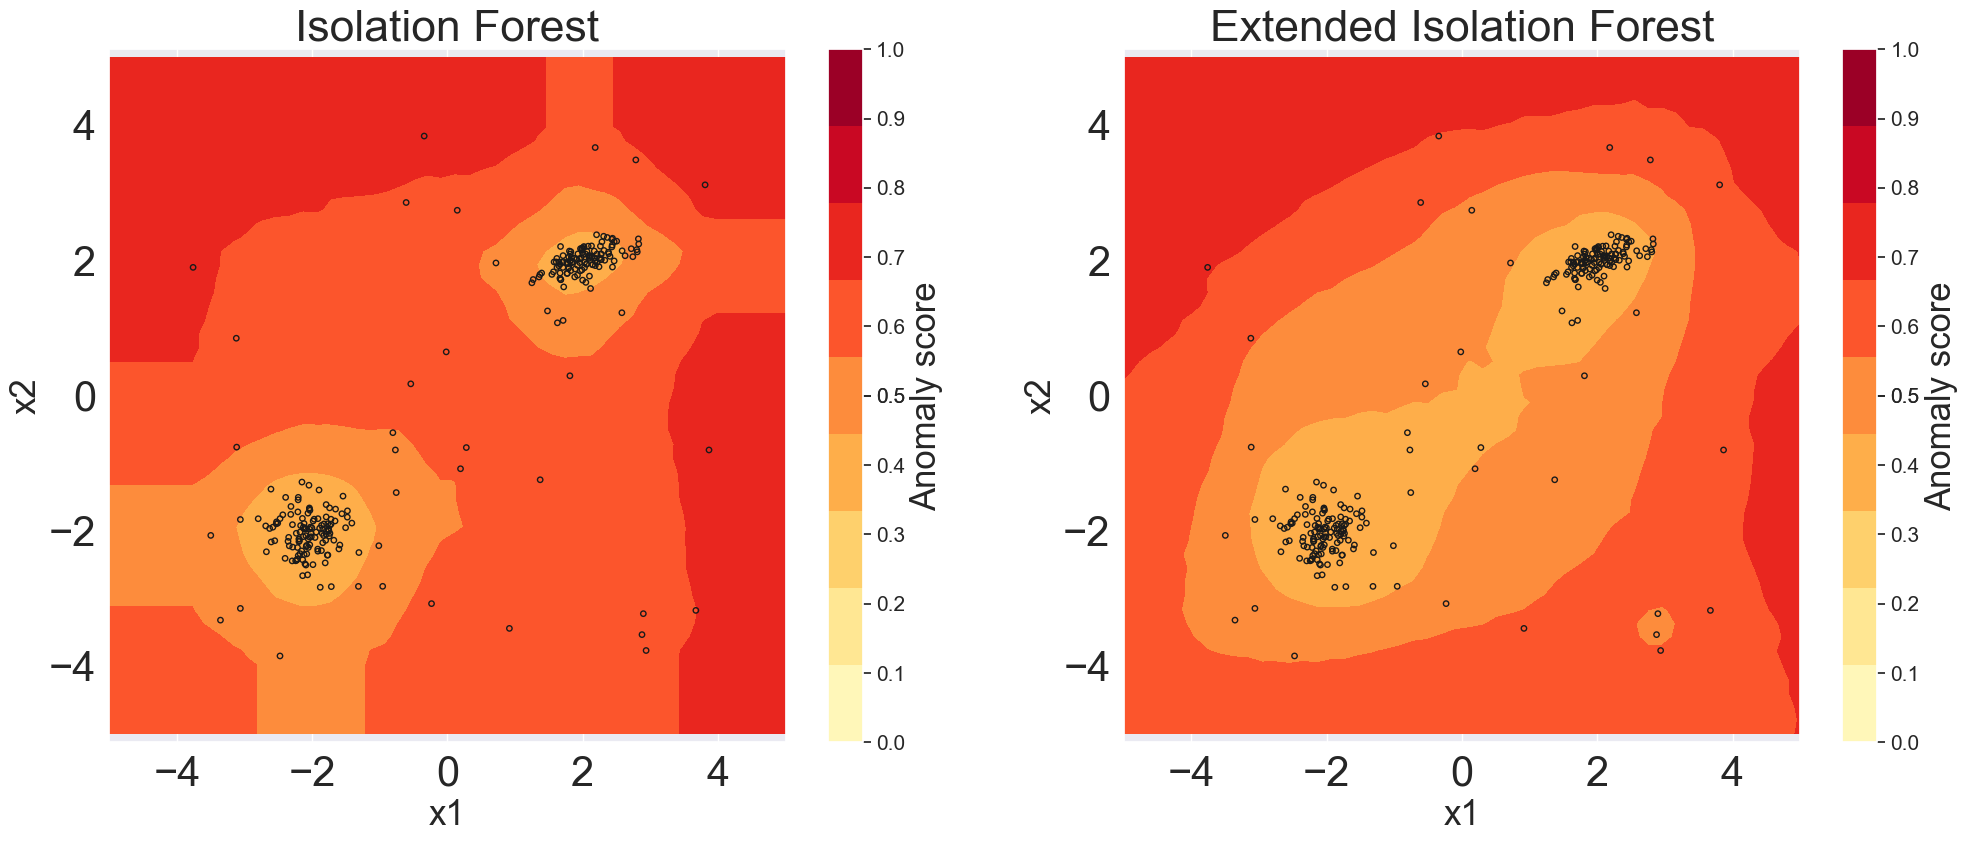

In [ ]:
j_var = plt.figure(figsize=(24, 9))

# объявим функцию для вывода подграфиков


def plot_heatmap(heatmap_data: np.ndarray, subplot: int, title: str) -> None:
    """Plot a heatmap with contour levels and scatter points."""
    ax1 = j_var.add_subplot(subplot)
    levels = np.linspace(0, 1, 10, endpoint=True)
    k_var = np.linspace(0, 1, 12, endpoint=True)
    k_var = np.around(k_var, decimals=1)
    c_s = ax1.contourf(xx, yy, heatmap_data, levels, cmap=plt.cm.YlOrRd)
    cbar = plt.colorbar(c_s, ticks=k_var)
    cbar.ax.set_ylabel("Anomaly score", fontsize=25)
    cbar.ax.tick_params(labelsize=15)
    ax1.set_xlabel("x1", fontsize=25)
    ax1.set_ylabel("x2", fontsize=25)
    plt.tick_params(labelsize=30)
    plt.scatter(h_var[:, 0], h_var[:, 1], s=15, c="None", edgecolor="k")
    plt.axis("equal")
    plt.title(title, fontsize=32)


# выведем тепловые карты
plot_heatmap(heatmap_h2o_if, 121, "Isolation Forest")
plot_heatmap(heatmap_h2o_eif, 122, "Extended Isolation Forest")

plt.show()